In [13]:
import pandas as pd
from glob import glob
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
%matplotlib inline


dummy = []
col_names = [
    "assets", "buying_date", "exit_date", "cost", "limit", "stop", "tolerace", "size", "result", "base_currency",
    "base_rate", "exit_currency", "exit_rate", "expectation", "leverage", "risk_reward"
]

def add_limit_pips(x):
    if x.exit_currency == "JPY":
        return np.abs(x.limit - x.cost) * 100
    else:
        return np.abs(x.limit - x.cost) * 10000
def add_stop_pips(x):
    if x.exit_currency == "JPY":
        return np.abs(x.stop - x.cost) * 100
    else:
        return np.abs(x.stop - x.cost) * 10000
def str_to_float(x):
    size = x["size"]
    if(isinstance(size, float)):
        return size
    return size.replace(",", "")
def exit_rate(x):
    if x.exit_currency == "JPY":
        return 1
    return x.exit_rate
def clean_rr(x):
    if x.risk_reward < 0:
        return None
    return x.risk_reward

path_ = glob("./data/sheets/* - total.csv")
for f_name in path_:
    tmp = pd.read_csv(f_name, names=col_names, header=0)
    tmp["f_name"] = f_name.split("/")[-1].split(" - ")[-1].split(".csv")[0]
    for d in ["buying_date", "exit_date"]:
        tmp[d] = pd.to_datetime(tmp[d], format="%Y/%m/%d")

    tmp["position"] = tmp.apply(lambda x: "long" if x.cost - x.stop > 0 else "short", axis=1)
    tmp["size"] = tmp.apply(lambda x: str_to_float(x), axis=1)
    tmp["exit_rate"] = tmp.apply(lambda x: exit_rate(x), axis=1)
    tmp["risk_reward"] = tmp.apply(lambda x: clean_rr(x), axis=1)
    tmp["limit_pips"] = tmp.apply(lambda x: add_limit_pips(x), axis=1)
    tmp["stop_pips"] = tmp.apply(lambda x: add_stop_pips(x), axis=1)
    dummy.append(tmp.dropna())
    
df = pd.concat(dummy).reset_index(drop=True)
df["positioning_period"] = (df.exit_date - df.buying_date)

df = df.drop(df[df.positioning_period.dt.days<0].index).reset_index(drop=True)
df["positioning_period"] = df.positioning_period.apply(lambda x: x.days)
# print(df.shape)
print("Average win rate: {}".format(df.result.mean()))

df.groupby("result").mean()


Average win rate: 0.31683168316831684


,cost,limit,stop,base_rate,exit_rate,expectation,leverage,risk_reward,limit_pips,stop_pips,positioning_period
result,,,,,,,,,,,
0,75.145478,75.403171,75.080760,104.195739,31.100145,13108.031754,1.370464,2.499507,310.589855,137.817391,20.043478
1,53.650765,53.889143,53.412273,109.400125,52.180000,11990.553406,1.008687,2.172500,337.000000,151.015625,47.062500


Minimum assets: 827830.268941118
Maximum assets: 1018841.2699919997
Final assets: 990480.5347119817


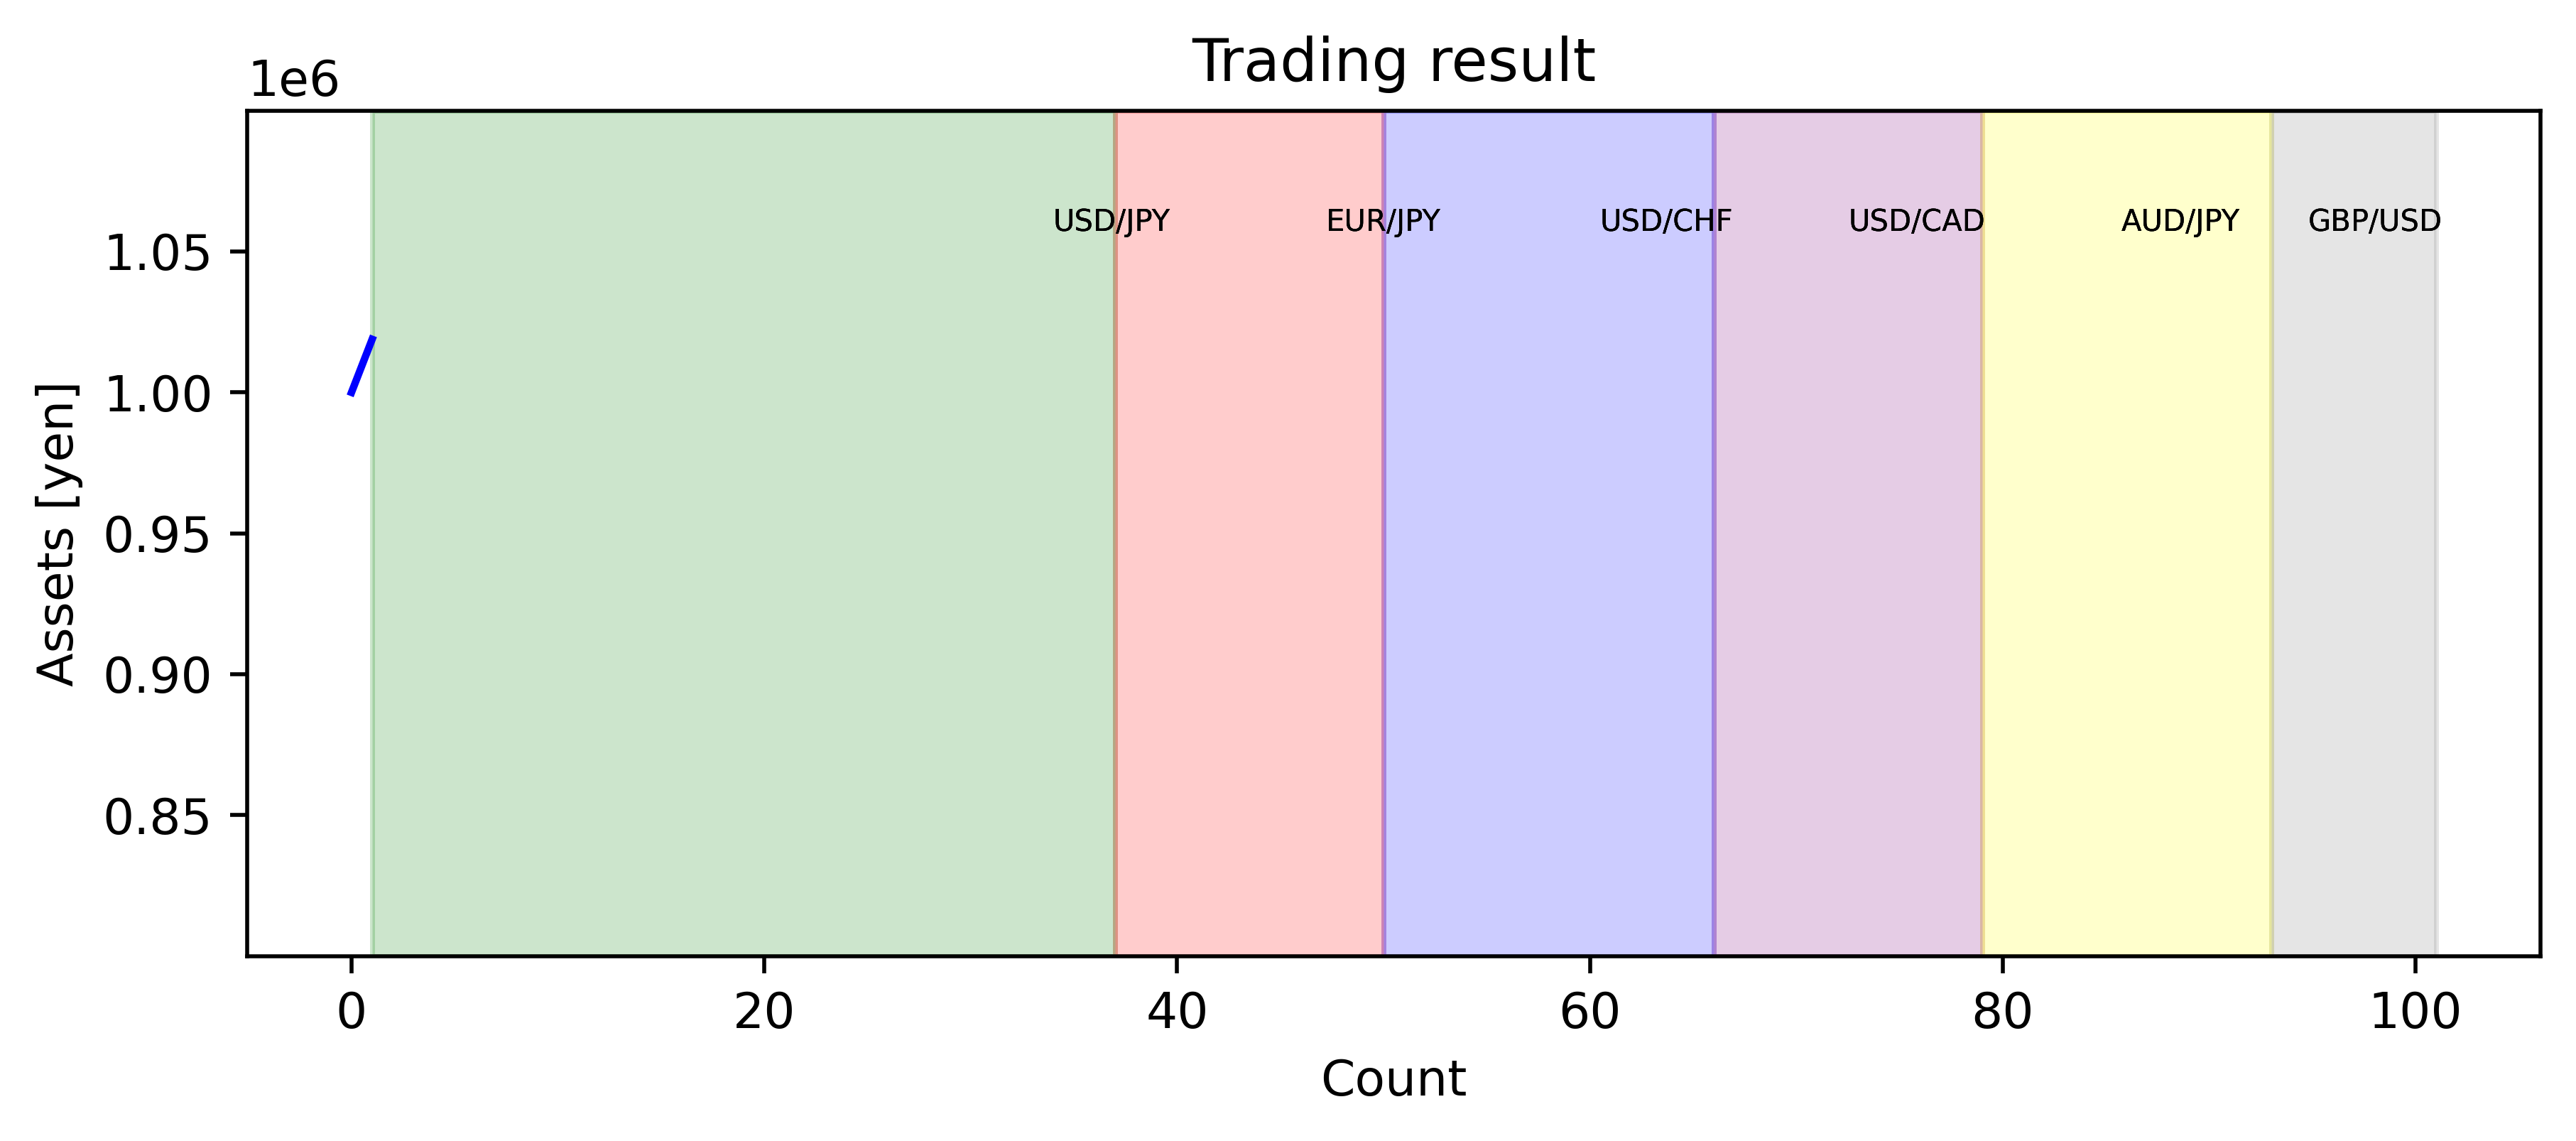

In [5]:
import matplotlib.animation as anm
from matplotlib.animation import PillowWriter
from matplotlib._version import get_versions as mplv

stack = []
assets = 1000000 #yen
stack.append([assets, None, None])

for idx, trading in df.iterrows():
    if trading["exit_currency"] == "JPY":
        rate = 1
    else:
        rate = trading["exit_rate"]
    if trading["result"] == 1:
        assets = assets + np.abs(trading["cost"] - trading["limit"]) * rate * float(trading["size"])
    else:
        assets = assets - np.abs(trading["cost"] - trading["stop"]) * rate * float(trading["size"])
    trading["acc"] = assets
    stack.append([assets, trading.base_currency, trading.exit_currency])
    
arr = np.array(stack)
print("Minimum assets: {}".format(min(arr[:, 0])))
print("Maximum assets: {}".format(max(arr[:, 0])))
print("Final assets: {}".format(arr[:, 0][-1]))

fig, ax = plt.subplots(figsize=(7, 3), dpi=500)

def update(i):
    if i != 0:
        plt.cla()
        
    fig.text(0.38, 0.80, "USD/JPY", size = 6, color = "black")
    fig.text(0.49, 0.80, "EUR/JPY", size = 6, color = "black")
    fig.text(0.60, 0.80, "USD/CHF", size = 6, color = "black")
    fig.text(0.70, 0.80, "USD/CAD", size = 6, color = "black")
    fig.text(0.81, 0.80, "AUD/JPY", size = 6, color = "black")
    fig.text(0.885, 0.80, "GBP/USD", size = 6, color = "black")

    ax.axvspan(1, 37, color="green", alpha=0.2) #USDJPY
    ax.axvspan(37, 50, color="red", alpha=0.2) #EURJPY
    ax.axvspan(50, 66, color="blue", alpha=0.2) #USDCHF
    ax.axvspan(66, 79, color="purple", alpha=0.2) #USDCAD
    ax.axvspan(79, 93, color="yellow", alpha=0.2) #AUDJPY
    ax.axvspan(93, 101, color="gray", alpha=0.2) #GBPUSD

    ax.set_ylim([800000, 1100000])
    ax.set_yticks(range(850000, 1100000, 50000))
    ax.plot(arr[:(i+1), 0].tolist(), color="blue")
    ax.set_xlabel("Count")
    ax.set_ylabel("Assets [yen]")
    ax.set_title("Trading result")
    fig.tight_layout()

anim_stack = [arr[:x, 0].tolist() for x in range(len(arr))]

anim = anm.FuncAnimation(fig, update, interval=500, frames=len(arr))

anim.save('./data/sheets/trading_result.gif', writer='pillow', dpi=100)

In [ ]:
def save_fig():
    fig, ax = plt.subplots(figsize=(7, 3), dpi=500)

    fig.text(0.38, 0.80, "USD/JPY", size = 6, color = "black")
    fig.text(0.49, 0.80, "EUR/JPY", size = 6, color = "black")
    fig.text(0.60, 0.80, "USD/CHF", size = 6, color = "black")
    fig.text(0.70, 0.80, "USD/CAD", size = 6, color = "black")
    fig.text(0.81, 0.80, "AUD/JPY", size = 6, color = "black")
    fig.text(0.885, 0.80, "GBP/USD", size = 6, color = "black")

    ax.axvspan(1, 37, color="green", alpha=0.2) #USDJPY
    ax.axvspan(37, 50, color="red", alpha=0.2) #EURJPY
    ax.axvspan(50, 66, color="blue", alpha=0.2) #USDCHF
    ax.axvspan(66, 79, color="purple", alpha=0.2) #USDCAD
    ax.axvspan(79, 93, color="yellow", alpha=0.2) #AUDJPY
    ax.axvspan(93, 101, color="gray", alpha=0.2) #GBPUSD

    ax.set_ylim([800000, 1100000])
    ax.set_yticks(range(850000, 1100000, 50000))
    ax.plot(arr[:, 0].tolist(), color="blue")
    ax.set_xlabel("Count")
    ax.set_ylabel("Assets [yen]")
    ax.set_title("Trading result")
    fig.tight_layout()
    fig.savefig("trading_result.jpg")

save_fig()